# About me

Juan Nunez-Iglesias  
CZI Imaging Software Fellow  
Monash University  

http://elegant-scipy.org

<a href="http://elegant-scipy.org">
<img src="https://github.com/elegant-scipy/elegant-scipy/blob/master/_images/cover.jpg?raw=true"
 alt="Elegant SciPy Cover" height=128 width=192 align="left">
</a>


# Quick example: gene expression, without numpy

| Gene   | Cell type A | Cell type B | Cell type C | Cell type D |
|--------|-------------|-------------|-------------|-------------|
| Gene 0 | 100         | 200         | 50          | 400         |
| Gene 1 | 50          | 0           | 0           | 100         |
| Gene 2 | 350         | 100         | 50          | 200         |

In [1]:
gene0 = [100, 200, 50, 400]
gene1 = [50, 0, 0, 100]
gene2 = [350, 100, 50, 200]
expression_data = [gene0, gene1, gene2]
expression_data

[[100, 200, 50, 400], [50, 0, 0, 100], [350, 100, 50, 200]]

Why is this a bad idea?

In [2]:
alist = [5, 'hello', 7.0, []]

# Now with NumPy

In [3]:
import numpy as np
a = np.array(expression_data)
print(a)

[[100 200  50 400]
 [ 50   0   0 100]
 [350 100  50 200]]


We are going to:

* Obtain an *RPKM* expression matrix
* Quantile normalize the data

using the awesome power of NumPy

# Inside a numpy ndarray

In [4]:
def print_info(a):
    print('number of elements:', a.size)
    print('number of dimensions:', a.ndim)
    print('shape:', a.shape)
    print('data type:', a.dtype)
    print('strides:', a.strides)
    print('flags:')
    print(a.flags)
    
print_info(a)

number of elements: 12
number of dimensions: 2
shape: (3, 4)
data type: int64
strides: (32, 8)
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



In [5]:
print(a.data)

In [6]:
abytes = a.ravel().view(dtype=np.uint8)

In [7]:
print_info(abytes)

number of elements: 96
number of dimensions: 1
shape: (96,)
data type: uint8
strides: (1,)
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



In [8]:
print(abytes[:24])

[100   0   0   0   0   0   0   0 200   0   0   0   0   0   0   0  50   0
   0   0   0   0   0   0]


In [9]:
abytes[1] = 1

In [10]:
a

array([[356, 200,  50, 400],
       [ 50,   0,   0, 100],
       [350, 100,  50, 200]])

In [13]:
b = np.empty_like(a)
b[:] = a[:]

In [15]:
a[[1, 1], [0, 2]]

array([50,  0])

### Example: take the transpose of `a`

In [16]:
print_info(a)

number of elements: 12
number of dimensions: 2
shape: (3, 4)
data type: int64
strides: (32, 8)
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



In [17]:
print_info(a.T)

number of elements: 12
number of dimensions: 2
shape: (4, 3)
data type: int64
strides: (8, 32)
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



### Example: skipping rows and columns with *slicing*

In [18]:
print_info(a.T)

number of elements: 12
number of dimensions: 2
shape: (4, 3)
data type: int64
strides: (8, 32)
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



In [19]:
print_info(a.T[::2])

number of elements: 6
number of dimensions: 2
shape: (2, 3)
data type: int64
strides: (16, 32)
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



In [21]:
a

array([[356, 200,  50, 400],
       [ 50,   0,   0, 100],
       [350, 100,  50, 200]])

In [20]:
a.T[::2]

array([[356,  50, 350],
       [ 50,   0,  50]])

In [22]:
print_info(a.T[::2, ::2])

number of elements: 4
number of dimensions: 2
shape: (2, 2)
data type: int64
strides: (16, 64)
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



### Getting a copy

In [23]:
b = a

In [24]:
print(b)

[[356 200  50 400]
 [ 50   0   0 100]
 [350 100  50 200]]


In [25]:
a[0, 0] = 5
print(b)
a[0, 0] = 100

[[  5 200  50 400]
 [ 50   0   0 100]
 [350 100  50 200]]


# Advanced operations: axis-wise evaluation

In [26]:
expr = np.load('expr.npy')

In [27]:
print_info(expr)

number of elements: 7687500
number of dimensions: 2
shape: (20500, 375)
data type: uint32
strides: (4, 82000)
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



In [28]:
np.sum(expr)

19873220752

This has the raw read count data. However, each sample gets a different number of reads, so we want to normalize by the *library size*, which is the total number of reads across a column.

The `np.sum` function returns the sum of all the elements of an array. With the `axis` argument, you can take the sum *along the given axis*.

In [29]:
lib_size = np.sum(expr, axis=0)

In [30]:
np.sum(expr, axis=(0, 1))

19873220752

### Exercise

Generate a 10 x 3 array of random numbers. From each row, pick the column containing the number closest to 0.75.

*Hint:* use of `np.abs` and `np.argmin` to find the column j that contains the closest element in each row i. The final result should be a vector of integers of shape (10,).

In [35]:
np.random.seed(0)

rand = np.random.random((10, 3))
d75 = np.abs(rand - 0.75)
mincols = np.argmin(d75, axis=1)
mincols

array([1, 2, 1, 1, 1, 2, 0, 2, 1, 0])

In [38]:
a[[1, 1], [0, 2]]

array([50,  0])

In [41]:
range(10)

range(0, 10)

In [42]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [43]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [44]:
row_coordinates = np.arange(10)
col_coordinates = mincols

rand[row_coordinates, col_coordinates]

array([0.71518937, 0.64589411, 0.891773  , 0.79172504, 0.92559664,
       0.83261985, 0.77815675, 0.78052918, 0.63992102, 0.94466892])

### Exercise

Some applications, such as clustering, are computationally expensive, and wouldn't work without first doing some form of *feature selection*, where we discard most of the data and keep only what we think will be most useful. One simple version is to keep only the genes with the most variance (as these will be more informative than genes that don't vary between patients).

- Find the variance across patients of all the genes (rows) in the expression dataset.
- Use `np.argsort` to find the location of the 1,500 most variable genes.
- Use these indices to produce a shape (1500, 375) matrix containing only the most variable genes.

In [45]:
var = np.var(expr, axis=1)
sorted_var_indices = np.argsort(var)
highest_var = sorted_var_indices[-1500:]

high_var_table = expr[highest_var]
high_var_table.shape

(1500, 375)

# Advanced operations: broadcasting

In order to normalize every column by its corresponding library size, we have to *align* the two arrays' axes: each dimension must be either the same size, or one of the arrays must have size 1. Use `np.newaxis` to match the dimensions. But let's first do some simple examples:

In [46]:
a + 5  # simplest "broadcasting": scalar - array operations

array([[105, 205,  55, 405],
       [ 55,   5,   5, 105],
       [355, 105,  55, 205]])

In [51]:
b = np.array([1, 2, 3, 4])
a + b  # broadcasting: coerce arrays to same shape by repeating as needed

array([[101, 202,  53, 404],
       [ 51,   2,   3, 104],
       [351, 102,  53, 204]])

In [52]:
print(a.shape)
print(b.reshape((1, 4)).shape)

(3, 4)
(1, 4)


In [49]:
b = np.array([1, 2, 3])
a + b  # broadcasting: not just magic!

ValueError: operands could not be broadcast together with shapes (3,4) (3,) 

In [53]:
b = np.array([[1], [2], [3]])
a + b  # broadcasting: shape compatibility

array([[101, 201,  51, 401],
       [ 52,   2,   2, 102],
       [353, 103,  53, 203]])

In [54]:
print(a.shape)
print(b.shape)

(3, 4)
(3, 1)


Now, back to our expression data.

In [55]:
print(expr.shape)
print(lib_size.shape)
print(lib_size[np.newaxis, :].shape)

(20500, 375)
(375,)
(1, 375)


However, NumPy will automatically prepend singleton dimensions until the array shapes match or there is an error:

In [56]:
np.all(expr / lib_size ==
       expr / lib_size[np.newaxis, :])

True

In [57]:
expr_lib = expr / lib_size

We also multiply by $10^6$ in order to keep the numbers on a readable scale (reads per million reads).

In [58]:
expr_lib *= 1e6

Finally, longer genes are more likely to produce reads. So we must normalize by the gene length (in kb) to produce a measure of expression called Reads Per Kilobase per Million reads (RPKM). We start by loading the gene lengths in *bases*. (1 kilobase = 1,000 bases.)

In [59]:
gene_len = np.load('gene-lens.npy')
print(gene_len.shape)

(20500,)


### Exercise: broadcast `expr_lib` and `gene_len` together to produce RPKM

In [68]:
print(expr_lib.shape)
print(gene_len.shape)
print(gene_len.T.shape)
print(gene_len.reshape((-1, 1)).shape)
print(gene_len[:, np.newaxis].shape)

(20500, 375)
(20500,)
(20500,)
(20500, 1)
(20500, 1)


Reminder:

$RPKM = \frac{C}{N \times 10^{-6} \times L \times 10^{-3}} = \frac{10^9C}{NL}$

where $C$ is the raw counts, $N$ is the library size (in reads) and $L$ is the gene length (in bases). 

In [69]:
rpkm = expr_lib / (gene_len[:, np.newaxis] * 1e-3) 

In order to admire our handywork, we will use a custom plotting function:

In [70]:
from matplotlib import pyplot as plt
from scipy import stats

def plot_col_density(data, xlim=None, *args, **kwargs):
    # Use gaussian smoothing to estimate the density
    density_per_col = [stats.kde.gaussian_kde(col) for col in data.T]
    if xlim is not None:
        m, M = xlim
    else:
        m, M = np.min(data), np.max(data)
    x = np.linspace(m, M, 100)

    fig, ax = plt.subplots()
    for density in density_per_col:
        ax.plot(x, density(x), *args, **kwargs)
    ax.set_xlabel('log-counts')
    ax.set_ylabel('frequency')
    if xlim is not None:
        ax.set_xlim(xlim)
    plt.show()


In [71]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

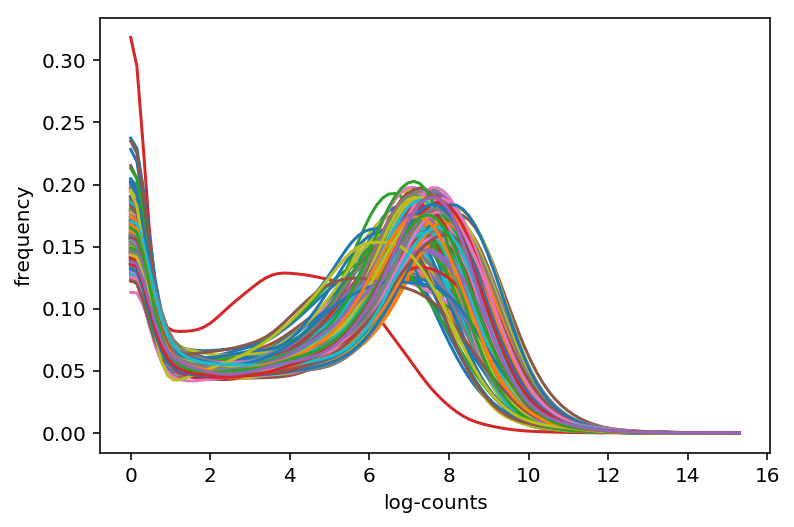

In [72]:
plot_col_density(np.log(expr+1))

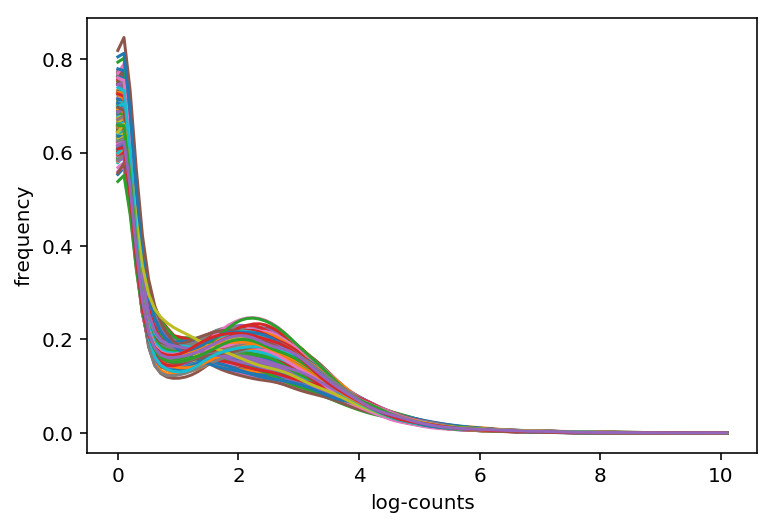

In [73]:
plot_col_density(np.log(rpkm + 1))

You should see that the most "disparate" data column is now a much better fit with the rest of the data. This should improve downstream scientific analysis.

In [75]:
x = np.array([1, 2, 2])
y = np.array([0, 2, 3, 7])

print(x.shape)
print(y.shape)

(3,)
(4,)


In [76]:
print(x[:, np.newaxis].shape)
print(y[np.newaxis, :].shape)

(3, 1)
(1, 4)


In [77]:
x[:, np.newaxis] + y[np.newaxis, :]

array([[1, 3, 4, 8],
       [2, 4, 5, 9],
       [2, 4, 5, 9]])

### Exercise: 3D broadcasting

Below, using broadcasting, produce the array containing the sum of every element in `x` with every element in `y`. That is, produce an array `z` such that `z[i, j, k]` contains either the sum of `x[i]` and `y[j, k]` OR the sum of `y[i, j]` and `x[k]`.

In [78]:
x = np.random.randint(10, size=8)
y = np.random.random(size=(3, 5))
z = x.reshape((1, 1, 8)) + y.reshape((3, 5, 1)) 

In [79]:
z.shape

(3, 5, 8)

### Exercise: explicit broadcasting and stride tricks

Now, use `np.broadcast_arrays` to `xbroad` and `ybroad` that are the same shape as `z` (so that a simple element-wise addition will give `z`). Then use `print_info` on `xbroad` and `ybroad`. Notice anything weird?

In [80]:
xbroad, ybroad = np.broadcast_arrays(x.reshape((1, 1, 8)), y.reshape((3, 5, 1)))

In [81]:
print(xbroad.shape)
print(ybroad.shape)

(3, 5, 8)
(3, 5, 8)


In [83]:
print_info(xbroad)

number of elements: 120
number of dimensions: 3
shape: (3, 5, 8)
data type: int64
strides: (0, 0, 8)
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True  (with WARN_ON_WRITE=True)
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



## Stride tricks

By manipulating the shape and strides of an array, we can produce a "virtual" array much bigger than its memory usage:

In [ ]:
def repeat(arr, n):
    return np.lib.stride_tricks.as_strided(arr,
                                           shape=(n,) + arr.shape,
                                           strides=(0,) + arr.strides)

In [ ]:
repeated_row = repeat(np.random.random(size=5), 4)
repeated_row

Be careful, though: some operations, such as `np.copy`, actually materialize the much bigger array!

In [ ]:
print_info(repeated_row)

In [ ]:
print_info(np.copy(repeated_row))

### Exercise

In [ ]:
x = np.random.random((3, 2)).astype(np.float32)

Try to answer these without looking at `x`. Then, try them out with the `print_info` function.

- What is the shape of `x`?
- What are the strides of `x`?
- Is `x` C-contiguous, F-contiguous, or neither?

Now let `y = repeat(x, 4)`. What is its shape? What are its strides? Is it contiguous?

### Exercise: `np.lib.stride_tricks.as_strided`

Use `as_strided` to produce a sliding-window view of a 1D array.

In [ ]:
def sliding_window(arr, size=2):
    """Produce an array of sliding window views of `arr`
    
    Parameters
    ----------
    arr : 1D array, shape (N,)
        The input array.
    size : int, optional
        The size of the sliding window.
        
    Returns
    -------
    arr_slide : 2D array, shape (N - size + 1, size)
        The sliding windows of size `size` of `arr`.
        
    Examples
    --------
    >>> a = np.array([0, 1, 2, 3])
    >>> sliding_window(a, 2)
    array([[0, 1],
           [1, 2],
           [2, 3]])
    """
    return ...  # fix this

In [ ]:
# test your code here
sliding_window(np.arange(8), 3)

### Exercise: mean filtering

Use `sliding_window` to implement mean filtering, in which every value in an array is replaced by the mean of it and its neighbours. This is a basic operation in signal processing.

In [ ]:
def mean_filter(signal, window_size=3):
    """Apply a mean filter to the input with the desired window size.
    
    Parameters
    ----------
    signal : 1D array, shape (M,)
        The input signal.
    window_size : int, optional
        The size of the window along which to compute the mean.
        
    Returns
    -------
    filtered : 1D array, shape (M - window_size + 1,)
        The filtered signal.
    """
    return ...  # FIX THIS

To test your function, we will use the example of a *difference filter*, which finds the location of changes in a signal using *convolution*. When the signal is perfectly noiseless, it works great:

In [ ]:
signal = np.zeros(100, np.float)
signal[30:60] = 1

diff = np.array([1, 0, -1])
from scipy import ndimage as ndi
dsignal = ndi.convolve(signal, diff)

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(signal)
ax[0].set_title('signal')
ax[1].plot(dsignal)
ax[1].set_title('change')
fig.tight_layout()

However, if the signal is corrupted by noise, a standard difference filter convolution doesn't work:

In [ ]:
np.random.seed(0)
signal_noisy = signal + np.random.normal(0, 0.3, size=signal.shape)
dsignal_noisy = ndi.convolve(signal_noisy, diff)

fig, ax = plt.subplots(1, 2)
ax[0].plot(signal_noisy)
ax[0].set_title('signal')
ax[1].plot(dsignal_noisy)
ax[1].set_title('change')
fig.tight_layout()

Try mean filtering with different window sizes to see whether the change signal becomes more apparent.

### Exercise: padding

What is the shape of your mean-filtered signal?

...

Oops! We've shortened the signal, which means that our indices have changed: `signal_filtered[i]` does not correspond to the signal around `signal[i]`.

Use `np.pad` to add some "fake" data around `signal` before filtering, so that the filtered result has the same shape as the input.

### Exercise: Gaussian filtering

It turns out that mean filtering is not the "optimal" way to recover your signal, assuming certain properties of the noise. For that, we use *Gaussian* filtering, which uses a *weighted* mean of the sliding window elements. The weights are given by the famous Gaussian bell-shaped distribution. For example, here are the weights for a window size of 17 for a particular sigma:

In [ ]:
weight = np.exp(-(np.arange(-8, 9) / (8/3))**2)
weight /= np.sum(weight)  ## ensure overall intensity of signal doesn't change
fig, ax = plt.subplots()
ax.plot(weight)

Write a function that uses sliding windows, broadcasting, and axis-wise operations to compute the Gaussian filter of a signal for a given window size. (You should also pad your input.)

# Fancy indexing

You can index arrays with slicing, but also with boolean arrays (including broadcasting!), integer arrays, and individual indices along multiple dimensions.

In [ ]:
values = np.array([0, 5, 99])
selector = np.random.randint(0, 3, size=(3, 4))
print(selector)
print(values[selector])

In [ ]:
relabeled = values[selector]
has_large_cols = np.any(relabeled > 10, axis=1)
print(relabeled[has_large_cols])

### Exercise

Use boolean indexing and broadcasting to select the columns of `relabeled` that do not contain 99.

### Example: quantile normalization

Quantile Normalization (https://en.wikipedia.org/wiki/Quantile_normalization) is a method to align distributions. Here we implement it using NumPy axis-wise operations and fancy indexing.

In [ ]:
def qnorm(X):
    """Quantile normalize an input matrix.
    
    Parameters
    ----------
    X : 2D array of float, shape (M, N)
        The input data, with each column being a
        distribution to normalize.
        
    Returns
    -------
    Xn : 2D array of float, shape (M, N)
        The normalized data.
    """
    ranks = ...
    return Xn

In [ ]:
logexpr = np.log(expr + 1)
logrpkm = np.log(rpkm + 1)

In [ ]:
logexprn = qnorm(logexpr)
logrpkmn = qnorm(logrpkm)

In [ ]:
plot_col_density(logexprn)

In [ ]:
plot_col_density(logrpkmn, xlim=(0, 0.25))

## Fancy indexing along multiple dimensions

Combining fancy indexing and slicing selects entire rows/columns:

In [ ]:
relabeled

In [ ]:
relabeled[[1, 1, 2], :]

In [ ]:
relabeled[:, [1, 3, 1]]

To select individual elements for a new array shape, we must use as many fancy indices as the array has dimensions:

In [ ]:
selector_rows = [[0, 0],
                 [1, 2]]
selector_cols = [[0, 3],
                 [1, 2]]

arr = np.arange(12).reshape((3, 4))
print(arr)

In [ ]:
print(arr[selector_rows, selector_cols])

One way to think about this is:
- make a "coordinate array", of the shape that you want plus one more axis, to hold the coordinates of each point (see below),
- transpose that final axis to the front, and
- convert to tuple

For the above example, perhaps you find this "notation", with the individual coordinates in the final axis, more intuitive:

In [ ]:
selector_t = [[ [0, 0], [0, 3] ],
              [ [1, 1], [2, 2] ]] 

That is, we want element (0, 0) in the top left corner, (0, 3) in the top right, (1, 1) in the bottom left, and (2, 3) in the bottom right. However, *rows and columns* must be in the first dimension and presented as a tuple to index the original array. So, to use this notation, we can use np.transpose and cast the result to `tuple`.

In [ ]:
selector = tuple(np.transpose(selector_t, (2, 0, 1)))
print(selector[0], selector[1], sep='\n')

For technical reasons that one might grasp for fleeting moments, the "tuple of index arrays" format is most consistent with other forms of multi-dimensional indexing in NumPy. It is a widespread convention (see e.g. `scipy.ndimage.map_coordinates`), so it's worth practicing.

### Exercise

What happens when you make `selector_col`:
- a single number?
- a 1D array with two elements?
- a 2D array of shape (1, 2)?
- a 1D array with three elements?

Repeat similar experiments with `selector_row`.

Does this remind you of any other NumPy feature we may have seen?

## Advanced exercise: Jack's dilemma

(If time permits.)

```email
Date: Wed, 16 Jul 2008 16:45:37 -0500
From: Jack Cook
To: <numpy-discussion@scipy.org>
Subject: Numpy Advanced Indexing Question
```

Greetings,

I have an I,J,K 3D volume of amplitude values at regularly sampled
time intervals. I have an I,J 2D slice which contains a time (K)
value at each I, J location. What I would like to do is extract a
subvolume at a constant +/- K window around the slice. Is there an
easy way to do this using advanced indexing or some other method?
Thanks in advanced for your help.

-- Jack

In [ ]:
# In the command-line, run `python tools/generate-volume.py`

data = np.load('geo.npz')  # npz file with multiple arrays, keyed like dict
strata, density = data['strata'], data['density']

In [ ]:
row = 256

fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(7.2, 3.6))
ax0.imshow(strata[:, row, :], cmap='gray')
ax0.set_ylabel('depth')
ax0.set_xlabel('x')
ax0.set_title(f'strata at row {row}')
ax1.imshow(density[:, 256, :], cmap='magma')
ax1.set_xlabel('x')
ax1.set_title(f'fossil density at row {row}') 

### Exercise

We want to quantify the apparent extinction event near a particular stratum. The strata, however, are not perfectly horizontal, and there is a large break in the rock, too. Therefore, we want to align the strata by using the solution to Jack's dilemma (which you must solve for him).

Using a window size of 120 (so the half-width is K=60):
- find the stratum of maximum intensity along the depth axis. This is a 2D slice of integers measuring the depth of the maximum intensity stratum at each (row, column) coordinate.
- using broadcasting, create a volume of shape (2K, Nrow, Ncol) containing the depth coordinate at each (row, column) of your desired window.
- create matching row and column index volumes to perform fancy indexing of the fossil density array.
- extract the subvolume of fossil density around the stratum using fancy indexing
- compute the mean fossil density at each depth.

**-->Advice<--**: play around with a much tinier subset of the volume, say, a subset of size (10, 15, 20), and window size of 3. Evaluating the wrong expression can result in a giant dataset that blows up your memory and crashes your computer. (Yay Science!)

## Linear algebra with NumPy

Since version 3.5, Python supports the matrix multiplication operator, denoted by the `@` symbol. This makes it a new powerhouse for linear algebra.

In [ ]:
M = np.array([[0, 1],
              [1, 1],
              [1, 0]])
v = np.array([9, 2])

print(M @ v)

In [ ]:
print(M.T @ M)

Now consider the rotation matrix

$
R = \begin{bmatrix}
  \cos \theta &  -\sin \theta & 0 \\
  \sin \theta & \cos \theta & 0\\
  0 & 0 & 1\\
\end{bmatrix}
$

When $R$ is multiplied with a 3-dimensional column-vector $p =
\left[ x\, y\, z \right]^T$, the resulting vector $R p$ is rotated
by $\theta$ degrees around the z-axis.

In [ ]:
theta_deg = 45
theta = np.deg2rad(theta_deg)

c = np.cos(theta)
s = np.sin(theta)

R = np.array([[c, -s, 0],
              [s,  c, 0],
              [0,  0, 1]]) 

In [ ]:
x_axis = np.array([1, 0, 0]) 

In [ ]:
R @ x_axis

In [ ]:
rotated = R @ x_axis
R @ rotated

### Exercise: rotation matrices

If you know some linear algebra, try to answer the following questions about $R$ in your head, before trying them out in Python. If you're totally stuck, just give them a go!

- What does the matrix $S = RR$ do? (Remember, `S = R @ R` in code.)
- What does $R^4 = RRRR$ do?
- The inverse $R^{-1}$ of $R$ is defined as the matrix such that $R^{-1}R = I$, where $I$ is the identity matrix. What does $Q = R^{-1}$ do? (Note: NumPy provides matrix inverse computation in `np.linalg.inv`.)
- What does $R$ do to the vector [0, 0, 1]?
- What does that make the vector [0, 0, 1]?
- Verify this with some function in `np.linalg`. (Look at the online documentation for this module.)
- What does $R^8$ do? What does that make $R^8$?

### Exercise: revisiting Gaussian filtering

Above, we performed Gaussian filtering with a broadcast product and a axis-wise sum. Use a matrix multiplication instead.

## Neural network with NumPy

In [ ]:
n = 20

In [ ]:
np.random.seed(128) 

In [ ]:
X = np.random.random(size=(n, 3)) 

- Make a vector y of length n that is 0 at position i if `X[i, 0] + X[i, 2] < 1`, and 1 otherwise.

*Hint:* How do I get the 0th column of X?

*Hint 2:* How can I convert an array of (True/False) to an array of float?

In [ ]:
X[2, 1]

In [ ]:
y = (X[:, 0] + X[:, 2] > 1).astype(float) 

In [ ]:
plt.scatter(X[:, 2], X[:, 0], color=plt.cm.viridis(y)) 

In [ ]:
X.shape

In [ ]:
X.size

In [ ]:
Xb = np.column_stack((X, np.ones(X.shape[0])))

In [ ]:
W = 2 * np.random.random(size=Xb.shape[1]) - 1

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
pred = sigmoid(Xb @ W)

In [ ]:
pred

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y, pred)

In [ ]:
def dsigmoid(x):
    return x * (1 - x)

In [ ]:
def train(X, y, W, n_iter=100):
    W_history = np.empty((n_iter, W.size), dtype=float)
    error_history = np.empty(n_iter, dtype=float)
    W_out = np.copy(W)
    for i in range(n_iter):
        W_history[i] = W_out
        predictions = sigmoid(X @ W_out)
        derror = y - predictions
        gradient = derror * dsigmoid(predictions)  # iamtrask
        update = X.T @ gradient
        error_history[i] = np.sum(np.abs(error))
        W_out += update
    return W_out, W_history, error_history

In [ ]:
Wout, Whist, errhist = train(Xb, y, W, 10000)

In [ ]:
fig, ax = plt.subplots()
ax.semilogx(errhist)

In [ ]:
np.mgrid[0:1:0.3, 0:1:0.3] 

In [ ]:
decision_space = np.mgrid[0:1:0.01, 0:1:1, 0:1:0.01, 1:2:1] 

In [ ]:
decision_space.shape

In [ ]:
prediction_image = sigmoid(decision_space.T @ Wout).T

In [ ]:
prediction_image.shape

In [ ]:
prediction_squeezed = np.squeeze(prediction_image) 

In [ ]:
fig, ax = plt.subplots()
ax.imshow(prediction_squeezed, cmap='magma', origin='lower',
          extent=[0, 1, 0, 1])
ax.scatter(X[:, 2], X[:, 0], color=plt.cm.viridis(y)) 

### Exercise

Why do some points appear misclassified?

*Hint:* Look at `Wout`.

# References and sources

In addition to original content, these notes use materials from the following sources:

- [100 NumPy Exercises](http://www.labri.fr/perso/nrougier/teaching/numpy.100/), compiled by Nicolas Rougier, used here under the terms of the MIT License.
- [SciPy Lecture Notes](http://www.scipy-lectures.org/), compiled by Gaël Varoquaux, Emmanuelle Gouillart, and Olav Vahtras, used under the terms of the CC-BY license.
- [Elegant SciPy](http://elegant-scipy.org), written by Juan Nunez-Iglesias, Stéfan van der Walt, and Harriet Dashnow, used with permission from O'Reilly.
- [iamtrask blog](https://iamtrask.github.io/2015/07/12/basic-python-network/), for a neural network from scratch that inspired this one.

They are all freely available online and worth checking out in their entirety!